# Predicting Loan Default: Part 3a

**Modelling**

I will be using 4 models
1. Multinomial Naive Bayes
2. Logistic Regression
3. Random Forest Classifier
4. XGBoost

This part includes modelling after the continuous features in the data set were converted to categorical features.

In [1]:
#Importing libraries

import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay 
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import re

%matplotlib inline

In [2]:
train = pd.read_csv('data/train_model_a.csv')

In [3]:
train = train.set_index('id')

In [4]:
from sklearn.preprocessing import LabelEncoder
for column in train.columns:
    if train[column].dtype==np.number:
        continue
    train[column]=LabelEncoder().fit_transform(train[column])

C:\Users\khogu\AppData\Local\Temp\ipykernel_27684\3845078900.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if train[column].dtype==np.number:
C:\Users\khogu\AppData\Local\Temp\ipykernel_27684\3845078900.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if train[column].dtype==np.number:
C:\Users\khogu\AppData\Local\Temp\ipykernel_27684\3845078900.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if train[column].dtype==np.number:
C:\Users\khogu\AppData\Local\Temp\ipykernel_27684\3845078900.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  if train[column].dt

In [5]:
train['loan_status'].value_counts()

0    61222
1     6241
Name: loan_status, dtype: int64

In [6]:
# create a new test dataset using 20% of the train data
train, test = train_test_split(train, test_size=0.2, stratify=train['loan_status'])

print(train['loan_status'].value_counts())
print(test['loan_status'].value_counts())

0    48977
1     4993
Name: loan_status, dtype: int64
0    12245
1     1248
Name: loan_status, dtype: int64


In [7]:
# Train test split
y = train['loan_status']
X = train.drop('loan_status', axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, stratify =y)

In [8]:
# Instantiate SMOTE
smote = SMOTE()

In [9]:
# Create empty dataframe to store results
model_results = pd.DataFrame(
    columns = [
        'classifier',
        'cv_train',
        'roc_auc_train',
        'roc_auc_val',
        'accuracy_train',
        'accuracy_val',
        'f1_val',
        'f1_train',
        'log_loss_train',
        'log_loss_val'
        ]
)

In [10]:
def run_grid(X_train, X_val, y_train, y_val):
    
    # Instantiate GridSearchCV
    gs = GridSearchCV(
        pipe, 
        param_grid = params, 
        n_jobs = -1, 
        cv = 5,
        scoring = 'neg_log_loss',
        verbose = 1
    )

    # Fit model
    gs.fit(X_train, y_train)

    # Get predictions
    preds = gs.predict(X_val)
    
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_val, preds).ravel()
    cm = confusion_matrix(y_val, preds)
    
    # View confusion matrix
    disp = ConfusionMatrixDisplay(cm)
    disp.plot()

    # Results row
    results_row = [{
        'classifier': pipe.steps[1][1],
        'cv_train': round(-gs.best_score_, 4), # <-- negate the score to get log loss
        'roc_auc_train': round(roc_auc_score(y_train, gs.predict_proba(X_train)[:, 1]), 4),
        'roc_auc_val': round(roc_auc_score(y_val, gs.predict_proba(X_val)[:, 1]), 4),
        'accuracy_train': round(accuracy_score(y_train, gs.predict(X_train)), 4), # <-- use accuracy_score function
        'accuracy_val': round(accuracy_score(y_val, preds), 4), # <-- use accuracy_score function
        'f1_val': round(f1_score(y_val, preds),4),
        'f1_train': round(f1_score(y_train, gs.predict(X_train)), 4),
        'log_loss_train': round(-gs.best_score_, 4), # <-- negate the score to get log loss
        'log_loss_val': round(log_loss(y_val, gs.predict_proba(X_val)[:, 1]), 4)
    }]
    
    # Print best parameters and scores from GridSearchCV
    print('Best Params:', gs.best_params_)
    print('Best Score:', -gs.best_score_)
            
    return results_row

**Multinomial Naive Bayes**

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, 

Best Params: {'nb__alpha': 1.5, 'nb__fit_prior': False, 'smote__sampling_strategy': 'minority'}
Best Score: 0.6758917063338924


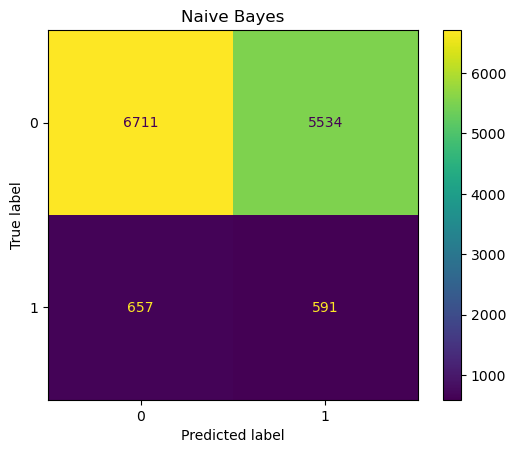

In [11]:
# instantiate MultinomialNB()

nb = MultinomialNB()

pipe = Pipeline([
        ('smote', smote),
        ('nb', nb)])

params = {
    'smote__sampling_strategy': ['float', 'minority'],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('Naive Bayes');

**Logistic Regression**

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X

Best Params: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'smote__sampling_strategy': 'minority'}
Best Score: 0.5796285183008955


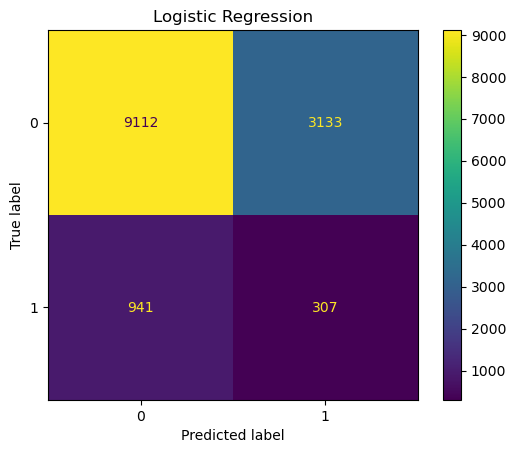

In [12]:
# Instantiate LogisticRegressionCV()

logreg = LogisticRegression()

pipe = Pipeline([
    ('smote', smote),
    ('logreg', logreg)])

params = {
    'smote__sampling_strategy': ['float', 'minority'],     
    'logreg__C': np.linspace(0.01, 0.1, 10), 
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']}


new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('Logistic Regression');

**Random Forest**

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, 

Best Params: {'rf__max_depth': 11, 'rf__n_estimators': 200, 'smote__sampling_strategy': 'minority'}
Best Score: 0.5402402588907668


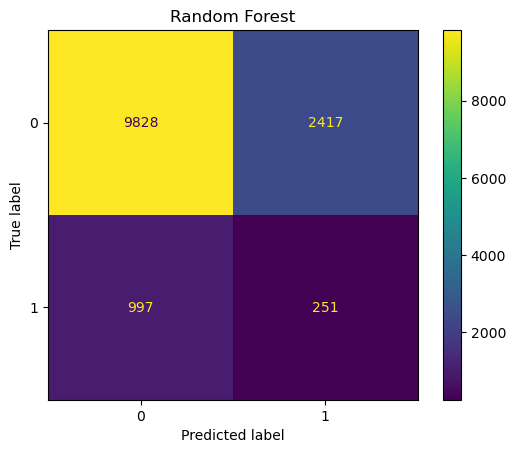

In [13]:
# Instantiate RandomForest Classifier

rf = RandomForestClassifier(random_state=42)

pipe = Pipeline([
    ('smote', smote),
    ('rf', rf)])

params = {
    'smote__sampling_strategy': ['float', 'minority'],     
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [7, 9, 11]
}


new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('Random Forest');

**XGBoost**

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X,

Best Params: {'smote__sampling_strategy': 'minority', 'xgb__learning_rate': 0.14, 'xgb__max_depth': 4, 'xgb__n_estimators': 150}
Best Score: 0.5161713545211244


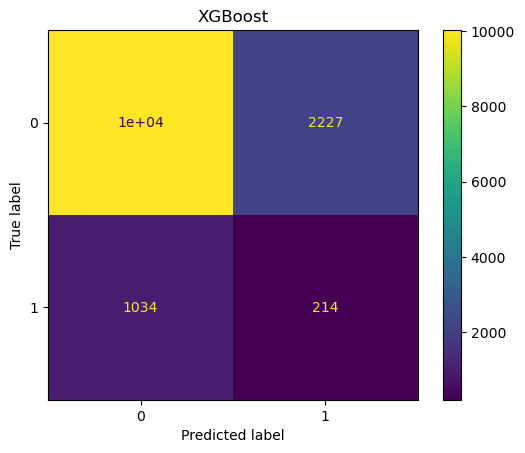

In [14]:
# Instantiate RandomForest Classifier

xgb = XGBClassifier(random_state=42)

pipe = Pipeline([
    ('smote', smote),
    ('xgb', xgb),
    ])

params = {
    'smote__sampling_strategy': ['float', 'minority'],
    'xgb__learning_rate': [0.10, 0.12, 0.14],
    'xgb__n_estimators': [100, 125, 150],
    'xgb__max_depth': [3, 4]
}


new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('XGBoost');

In [15]:
model_results

,classifier,cv_train,roc_auc_train,roc_auc_val,accuracy_train,accuracy_val,f1_val,f1_train,log_loss_train,log_loss_val
0,MultinomialNB(),0.6759,0.5054,0.5110,0.5399,0.5412,0.1603,0.1583,0.6759,0.6782
0,LogisticRegression(),0.5796,0.4889,0.4875,0.6969,0.6981,0.1310,0.1325,0.5796,0.5836
0,RandomForestClassifier(random_state=42),0.5402,0.7535,0.4960,0.7832,0.7470,0.1282,0.2458,0.5402,0.5479
0,"XGBClassifier(base_score=None, booster=None, c...",0.5162,0.5635,0.4902,0.7727,0.7583,0.1160,0.1471,0.5162,0.5231


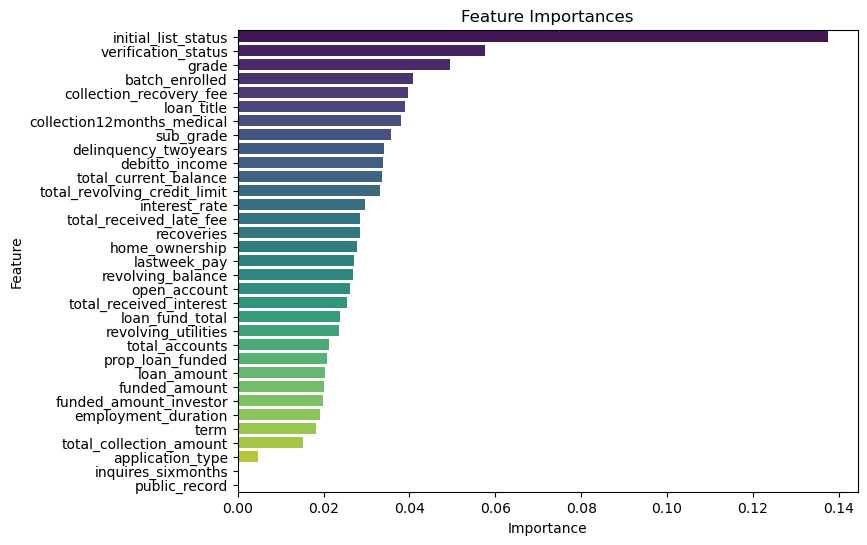

In [16]:
# Fit XGBoost with best parameters
xgb = XGBClassifier(random_state=42, learning_rate=0.14, max_depth=4, n_estimators=150)
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
xgb.fit(X_train_resampled, y_train_resampled)

# Extract feature importances
feature_importances = xgb.feature_importances_
features = X_train.columns.tolist()

# Create a dataframe with feature importances
fi_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
fi_df = fi_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis')
plt.title('Feature Importances')
plt.show()

**Feature Reduction**

I will now use the top 25 features in the above feature importance plot to run the models again.

In [17]:
# Train test split
drop_features = ['loan_status', 'total_collection_amount', 'revolving_utilities',
               'funded_amount', 'employment_duration', 'term', 'application_type',
               'inquires_sixmonths', 'public_record']

y = train['loan_status']
X = train.drop(drop_features, axis=1)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42, stratify =y)

**Multinomial Naive Bayes**

Fitting 5 folds for each of 8 candidates, totalling 40 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
2 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, 

Best Params: {'nb__alpha': 0.5, 'nb__fit_prior': True, 'smote__sampling_strategy': 'minority'}
Best Score: 0.6813180817362102


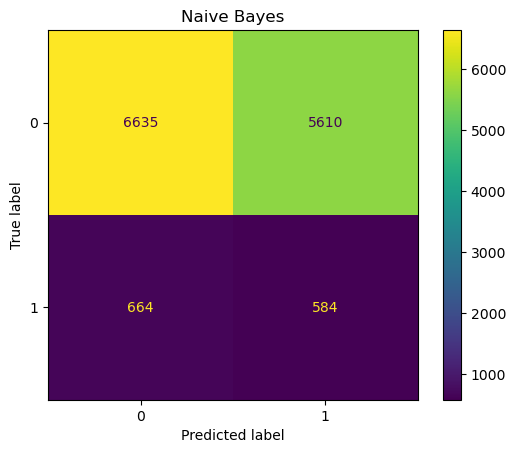

In [18]:
# instantiate MultinomialNB()

nb = MultinomialNB()

pipe = Pipeline([
        ('smote', smote),
        ('nb', nb)])

params = {
    'smote__sampling_strategy': ['float', 'minority'],
    'nb__alpha': np.linspace(0.5, 1.5, 2),
    'nb__fit_prior': [True, False]
}

new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('Naive Bayes');

**Logistic Regression**

Fitting 5 folds for each of 40 candidates, totalling 200 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
100 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    

Best Params: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'smote__sampling_strategy': 'minority'}
Best Score: 0.5912907965389802


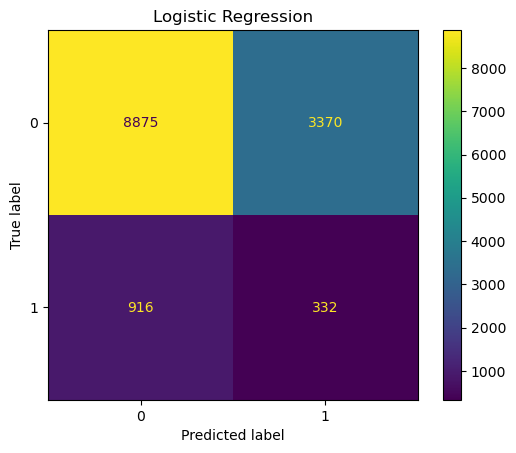

In [19]:
# Instantiate LogisticRegressionCV()

logreg = LogisticRegression()

pipe = Pipeline([
    ('smote', smote),
    ('logreg', logreg)])

params = {
    'smote__sampling_strategy': ['float', 'minority'],     
    'logreg__C': np.linspace(0.01, 0.1, 10), 
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear']}


new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('Logistic Regression');

**Random Forest**

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X, 

Best Params: {'rf__max_depth': 11, 'rf__n_estimators': 200, 'smote__sampling_strategy': 'minority'}
Best Score: 0.5492235235066403


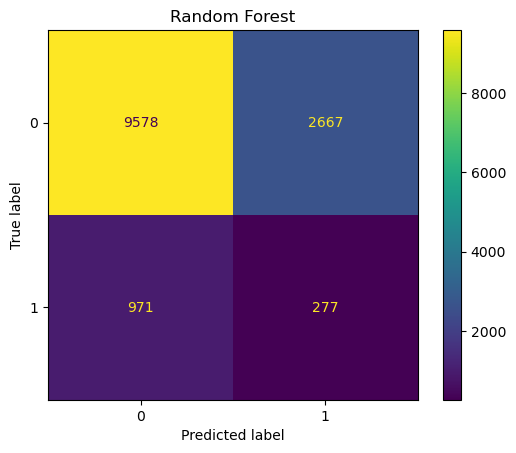

In [20]:
# Instantiate RandomForest Classifier

rf = RandomForestClassifier(random_state=42)

pipe = Pipeline([
    ('smote', smote),
    ('rf', rf)])

params = {
    'smote__sampling_strategy': ['float', 'minority'],     
    'rf__n_estimators': [100, 150, 200],
    'rf__max_depth': [7, 9, 11]
}


new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('Random Forest');

**XGBoost**

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
90 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 293, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\khogu\AppData\Roaming\Python\Python39\site-packages\imblearn\pipeline.py", line 250, in _fit
    X

Best Params: {'smote__sampling_strategy': 'minority', 'xgb__learning_rate': 0.14, 'xgb__max_depth': 4, 'xgb__n_estimators': 150}
Best Score: 0.5370724739629064


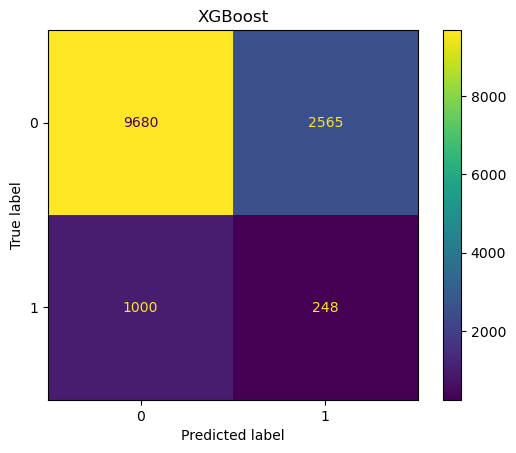

In [21]:
# Instantiate XGBoost Classifier

xgb = XGBClassifier(random_state=42)

pipe = Pipeline([
    ('smote', smote),
    ('xgb', xgb),
    ])

params = {
    'smote__sampling_strategy': ['float', 'minority'],
    'xgb__learning_rate': [0.10, 0.12, 0.14],
    'xgb__n_estimators': [100, 125, 150],
    'xgb__max_depth': [3, 4]
}


new_results = run_grid(X_train, X_val, y_train, y_val)
model_results = pd.concat([model_results, pd.DataFrame(new_results)], axis = 0)
plt.title('XGBoost');

In [22]:
model_results

,classifier,cv_train,roc_auc_train,roc_auc_val,accuracy_train,accuracy_val,f1_val,f1_train,log_loss_train,log_loss_val
0,MultinomialNB(),0.6759,0.5054,0.5110,0.5399,0.5412,0.1603,0.1583,0.6759,0.6782
0,LogisticRegression(),0.5796,0.4889,0.4875,0.6969,0.6981,0.1310,0.1325,0.5796,0.5836
0,RandomForestClassifier(random_state=42),0.5402,0.7535,0.4960,0.7832,0.7470,0.1282,0.2458,0.5402,0.5479
0,"XGBClassifier(base_score=None, booster=None, c...",0.5162,0.5635,0.4902,0.7727,0.7583,0.1160,0.1471,0.5162,0.5231
0,MultinomialNB(),0.6813,0.4984,0.5040,0.5315,0.5350,0.1569,0.1539,0.6813,0.6817
0,LogisticRegression(),0.5913,0.4933,0.4898,0.6842,0.6824,0.1341,0.1373,0.5913,0.5962
0,RandomForestClassifier(random_state=42),0.5492,0.7486,0.4969,0.7708,0.7304,0.1322,0.2509,0.5492,0.5584
0,"XGBClassifier(base_score=None, booster=None, c...",0.5371,0.5645,0.4913,0.7494,0.7358,0.1221,0.1535,0.5371,0.5484


**Results and model choice**

I picked the first run of the XGBoost model without reducing to the top 25 features because it is less over fitted than the other models, it has decent accuracy scores, and is the best in log loss scores.

Best Params: {'smote__sampling_strategy': 'minority', 'xgb__learning_rate': 0.14, 'xgb__max_depth': 4, 'xgb__n_estimators': 150} Best Score: 0.5161713545211244